# 3.1 추론 기반 기법과 신경망

3.1.3 신경망에서의 단어 처리

In [ ]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력, 원핫 표현
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[[-0.34433607 -0.02031588 -0.30160569]]


In [3]:
# MatMul 계층으로 구현
import numpy as np
from layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.19039801  0.74592934  0.41396724]]


# 3.2 단순한 word2vec

3.2.1 CBOW 모델의 추론 처리

In [ ]:
import numpy as np
from layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([1, 0, 0, 0, 0, 0 ,0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1) # 평균
s = out_layer.forward(h)

print(s)

[-2.08053005  1.59653047 -2.16950508  0.90080841  2.11809531  2.11171153
 -1.47841862]


# 3.3 학습 데이터 준비

3.3.1 맥락과 타깃

In [18]:
from utils import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [19]:
corpus[1: -1], corpus[2: -2], corpus[3: -3]

(array([1, 2, 3, 4, 1, 5]), array([2, 3, 4, 1]), array([3, 4]))

In [21]:
for i in range(-2, 3):
    print(i)

-2
-1
0
1
2


In [3]:
from utils import preprocess, create_contexts_target

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


3.3.2 원핫 표현으로 변환

In [1]:
from utils import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


# 3.4 CBOW 모델 구현

In [1]:
import numpy as np
from layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

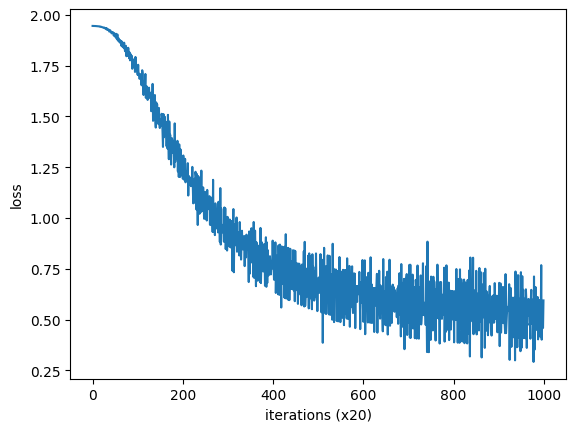

In [3]:
from trainer import Trainer
from optimizer import SGD, Adam
from utils import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
# optimizer = SGD()
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
word_vecs = model.word_vecs # 입력 가중치, 각 행에는 대응하는 단어 ID의 분산표현
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# 이 밀집벡터가 바로 단어의 분산표현

you [ 0.9728107 -1.0701395 -1.3182739 -1.36667    0.97889  ]
say [-1.3001401   0.550203    0.27883095 -0.04338162 -1.330512  ]
goodbye [ 0.89410555 -0.99045926 -0.47973007 -0.46577486  0.8575128 ]
and [-1.0688792  1.3540934 -1.5112468 -1.3853227 -1.0842128]
i [ 0.9032744  -1.0267723  -0.4851217  -0.4843883   0.84249836]
hello [ 0.9731183 -1.0774567 -1.3151778 -1.3547958  0.9591239]
. [-1.122188  -1.5641391  1.2514209  1.2683054 -1.1571064]
